# Tutorial: optimal binning with binary target under uncertainty

The drawback of performing optimal binning given only expected event rates is that variability of event rates in different periods is not taken into account. In this tutorial, we show how scenario-based stochastic programming allows incorporating uncertainty without much difficulty.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats

In [2]:
from optbinning import OptimalBinning
from optbinning.binning.uncertainty import SBOptimalBinning

### Scenario generation

We generate three scenarios, all equally likely, aiming to represent three economic scenarios severity using the customer's score variable, for instance.

**Scenario 0 - Normal (Realistic)**: A low customer' score has a higher event rate (default rate, churn, etc) than a high customer's score. The population corresponding to non-event and event are reasonably separated.

In [3]:
N0 = int(1e5)

xe = stats.beta(a=4, b=15).rvs(size=N0, random_state=42)
ye = stats.bernoulli(p=0.7).rvs(size=N0, random_state=42)
xn = stats.beta(a=6, b=8).rvs(size=N0, random_state=42)
yn = stats.bernoulli(p=0.2).rvs(size=N0, random_state=42)

x0 = np.concatenate((xn, xe), axis=0)
y0 = np.concatenate((yn, ye), axis=0)

In [4]:
def plot_distribution(x, y):
    plt.hist(x[y == 0], label="n_nonevent", color="b", alpha=0.5)
    plt.hist(x[y == 1], label="n_event", color="r", alpha=0.5)
    plt.legend()
    plt.show()

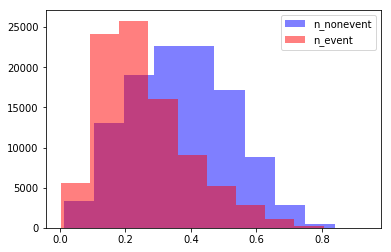

In [5]:
plot_distribution(x0, y0)

**Scenario 1: Good (Optimistic)**: A low customer' score has a much higher event rate (default rate, churn, etc) than a high customer's score. The population corresponding to non-event and event rate are very well separated, showing minimum overlap regions.

In [6]:
N1 = int(5e4)

xe = stats.beta(a=25, b=50).rvs(size=N1, random_state=42)
ye = stats.bernoulli(p=0.9).rvs(size=N1, random_state=42)
xn = stats.beta(a=22, b=25).rvs(size=N1, random_state=42)
yn = stats.bernoulli(p=0.05).rvs(size=N1, random_state=42)

x1 = np.concatenate((xn, xe), axis=0)
y1 = np.concatenate((yn, ye), axis=0)

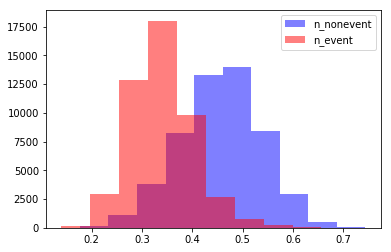

In [7]:
plot_distribution(x1, y1)

**Scenario 2: Bad (Pessimistic)**: Customer's behavior cannot be accurately segmented, and a general increase in event rates is exhibited. The populations corresponding to non-event and event are practically overlapped.

In [8]:
N2 = int(5e4)

xe = stats.beta(a=4, b=6).rvs(size=N2, random_state=42)
ye = stats.bernoulli(p=0.7).rvs(size=N2, random_state=42)
xn = stats.beta(a=8, b=10).rvs(size=N2, random_state=42)
yn = stats.bernoulli(p=0.4).rvs(size=N2, random_state=42)

x2 = np.concatenate((xn, xe), axis=0)
y2 = np.concatenate((yn, ye), axis=0)

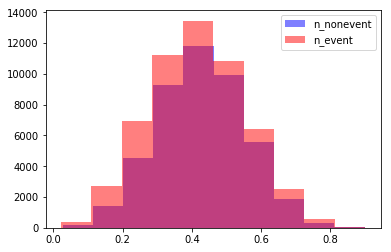

In [9]:
plot_distribution(x2, y2)

### Scenario-based stochastic optimal binning

Prepare scenarios data and instantiate an ``SBOptimalBinning`` object class. We set a descending monotonicity constraint with respect to event rate and a minimum bin size.

In [10]:
X = [x0, x1, x2]
Y = [y0, y1, y2]

In [11]:
sboptb = SBOptimalBinning(monotonic_trend="descending", min_bin_size=0.05)
sboptb.fit(X, Y)

SBOptimalBinning(min_bin_size=0.05, monotonic_trend='descending')

In [12]:
sboptb.status

'OPTIMAL'

We obtain "only" three splits guaranteeing feasibility for each scenario.

In [13]:
sboptb.splits

array([0.28578988, 0.33941348, 0.43260857])

In [14]:
sboptb.information(print_level=2)

optbinning (Version 0.17.1)
Copyright (c) 2019-2022 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    name                                       * d
    prebinning_method                   cart   * d
    max_n_prebins                         20   * d
    min_prebin_size                     0.05   * d
    min_n_bins                            no   * d
    max_n_bins                            no   * d
    min_bin_size                        0.05   * U
    max_bin_size                          no   * d
    monotonic_trend               descending   * U
    min_event_rate_diff                    0   * d
    max_pvalue                            no   * d
    max_pvalue_policy            consecutive   * d
    class_weight                          no   * d
    user_splits                           no   * d
    user_splits_fixed                     no   * d
    special_codes                         no   * d
    split_digits                          no   * d
    time_limit     

#### The binning table

As other optimal binning algorithms in OptBinning, ``SBOptimalBinning`` also returns a binning table displaying the binned data considering all scenarios.

In [15]:
sboptb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.29)",119678,0.299195,42005,77673,0.649017,-0.688603,0.138209,0.016943
1,"[0.29, 0.34)",53792,0.134480,21149,32643,0.606837,-0.507921,0.034281,0.004240
2,"[0.34, 0.43)",94315,0.235788,50733,43582,0.462090,0.078049,0.001434,0.000179
3,"[0.43, inf)",132215,0.330537,93498,38717,0.292834,0.807778,0.201811,0.024562
4,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
Totals,,400000,1.000000,207385,192615,0.481538,,0.375735,0.045924


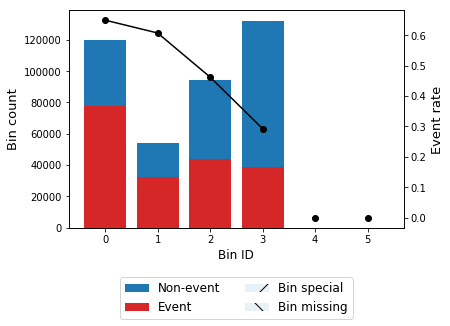

In [16]:
sboptb.binning_table.plot(metric="event_rate")

In [17]:
sboptb.binning_table.analysis()

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.32783732
    IV (Jeffrey)             0.37573525
    JS (Jensen-Shannon)      0.04592372
    Hellinger                0.04643791
    Triangular               0.17975000
    KS                       0.26820258
    HHI                      0.27245330
    HHI (normalized)         0.12694396
    Cramer's V               0.29928851
    Quality score            0.87078922

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic      p-value  P[A > B]     P[B > A]
        0      1   285.174852 5.596834e-64       1.0 1.110223e-16
        1      2  2873.289985 0.000000e+00       1.0 1.110223e-16
        2      3  6817.466845 0.000000e+00       1.0 1.110223e-16



### Expected value solution (EVS)

The expected value solution is calculated with the normal (expected) scenario.

In [18]:
optb = OptimalBinning(monotonic_trend="descending", min_bin_size=0.05)
optb.fit(x0, y0)

OptimalBinning(min_bin_size=0.05, monotonic_trend='descending')

In [19]:
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.10)",10255,0.051275,3061,7194,0.701511,-1.054853,0.054945,0.006566
1,"[0.10, 0.14)",12519,0.062595,3911,8608,0.687595,-0.989246,0.059422,0.007139
2,"[0.14, 0.18)",18333,0.091665,6065,12268,0.669176,-0.904807,0.073418,0.008877
3,"[0.18, 0.20)",13631,0.068155,4884,8747,0.641699,-0.783094,0.041320,0.005037
4,"[0.20, 0.23)",14606,0.073030,5684,8922,0.610845,-0.651212,0.030891,0.003795
5,"[0.23, 0.27)",17995,0.089975,8043,9952,0.553043,-0.413319,0.015470,0.001920
6,"[0.27, 0.30)",13047,0.065235,6672,6375,0.488618,-0.154812,0.001572,0.000196
7,"[0.30, 0.35)",18825,0.094125,11158,7667,0.407278,0.174884,0.002847,0.000355
8,"[0.35, 0.39)",16401,0.082005,10903,5498,0.335223,0.484306,0.018430,0.002282
9,"[0.39, 0.44)",18759,0.093795,13688,5071,0.270324,0.792634,0.053994,0.006578


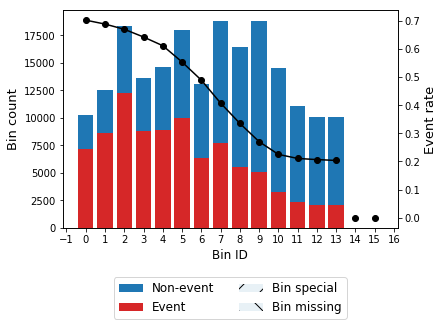

In [20]:
optb.binning_table.plot(metric="event_rate")

In [21]:
optb.binning_table.analysis()

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.42141055
    IV (Jeffrey)             0.59497411
    JS (Jensen-Shannon)      0.07160267
    Hellinger                0.07295186
    Triangular               0.27638899
    KS                       0.34108533
    HHI                      0.07501900
    HHI (normalized)         0.01335360
    Cramer's V               0.36927482
    Quality score            0.16335319

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic      p-value  P[A > B]     P[B > A]
        0      1     5.139745 2.338408e-02  0.988706 1.129409e-02
        1      2    11.534993 6.829832e-04  0.999721 2.787731e-04
        2      3    26.208899 3.064073e-07  1.000000 7.445353e-09
        3      4    28.661681 8.619251e-08  1.000000 4.436704e-09
        4      5   110.500800 7.611468e-26  1.00

### Scenario analysis

#### Scenario 0 - Normal (Realistic)

In [22]:
bt0 = sboptb.binning_table_scenario(scenario_id=0)
bt0.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.29)",93851,0.469255,34903,58948,0.628102,-0.724430,0.244506,0.029912
1,"[0.29, 0.34)",22545,0.112725,12817,9728,0.431493,0.075417,0.000638,0.000080
2,"[0.34, 0.43)",34084,0.170420,23417,10667,0.312962,0.585960,0.055321,0.006818
3,"[0.43, inf)",49520,0.247600,38847,10673,0.215529,1.091566,0.256123,0.030515
4,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000
Totals,,200000,1.000000,109984,90016,0.450080,,0.556589,0.067325


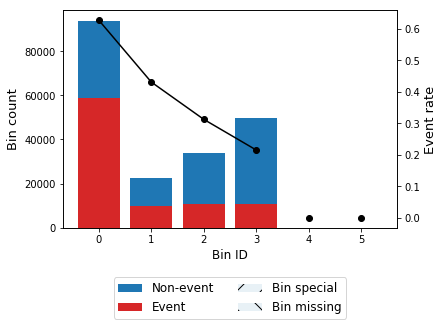

In [23]:
bt0.plot(metric="event_rate")

In [24]:
optb0 = OptimalBinning(monotonic_trend="descending", min_bin_size=0.05)
optb0.fit(x0, y0)

OptimalBinning(min_bin_size=0.05, monotonic_trend='descending')

In [25]:
optb0.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.10)",10255,0.051275,3061,7194,0.701511,-1.054853,0.054945,0.006566
1,"[0.10, 0.14)",12519,0.062595,3911,8608,0.687595,-0.989246,0.059422,0.007139
2,"[0.14, 0.18)",18333,0.091665,6065,12268,0.669176,-0.904807,0.073418,0.008877
3,"[0.18, 0.20)",13631,0.068155,4884,8747,0.641699,-0.783094,0.041320,0.005037
4,"[0.20, 0.23)",14606,0.073030,5684,8922,0.610845,-0.651212,0.030891,0.003795
5,"[0.23, 0.27)",17995,0.089975,8043,9952,0.553043,-0.413319,0.015470,0.001920
6,"[0.27, 0.30)",13047,0.065235,6672,6375,0.488618,-0.154812,0.001572,0.000196
7,"[0.30, 0.35)",18825,0.094125,11158,7667,0.407278,0.174884,0.002847,0.000355
8,"[0.35, 0.39)",16401,0.082005,10903,5498,0.335223,0.484306,0.018430,0.002282
9,"[0.39, 0.44)",18759,0.093795,13688,5071,0.270324,0.792634,0.053994,0.006578


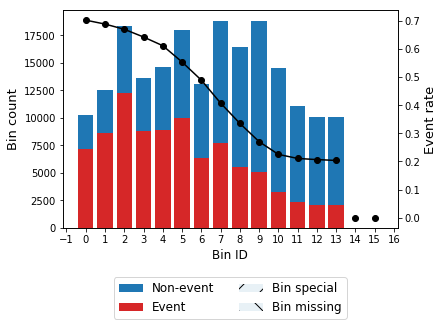

In [26]:
optb0.binning_table.plot(metric="event_rate")

Apply expected value solution to scenario 0.

In [27]:
evs_optb0 = OptimalBinning(user_splits=optb.splits)
evs_optb0.fit(x0, y0)

OptimalBinning(user_splits=array([0.1008646 , 0.13640077, 0.17635711, 0.20390539, 0.23334569,
       0.27135116, 0.30051835, 0.34623086, 0.38964605, 0.44464479,
       0.49356021, 0.53990114, 0.59801421]))

In [28]:
evs_optb0.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.10)",10255,0.051275,3061,7194,0.701511,-1.054853,0.054945,0.006566
1,"[0.10, 0.14)",12519,0.062595,3911,8608,0.687595,-0.989246,0.059422,0.007139
2,"[0.14, 0.18)",18333,0.091665,6065,12268,0.669176,-0.904807,0.073418,0.008877
3,"[0.18, 0.20)",13631,0.068155,4884,8747,0.641699,-0.783094,0.041320,0.005037
4,"[0.20, 0.23)",14606,0.073030,5684,8922,0.610845,-0.651212,0.030891,0.003795
5,"[0.23, 0.27)",17995,0.089975,8043,9952,0.553043,-0.413319,0.015470,0.001920
6,"[0.27, 0.30)",13047,0.065235,6672,6375,0.488618,-0.154812,0.001572,0.000196
7,"[0.30, 0.35)",18825,0.094125,11158,7667,0.407278,0.174884,0.002847,0.000355
8,"[0.35, 0.39)",16401,0.082005,10903,5498,0.335223,0.484306,0.018430,0.002282
9,"[0.39, 0.44)",18759,0.093795,13688,5071,0.270324,0.792634,0.053994,0.006578


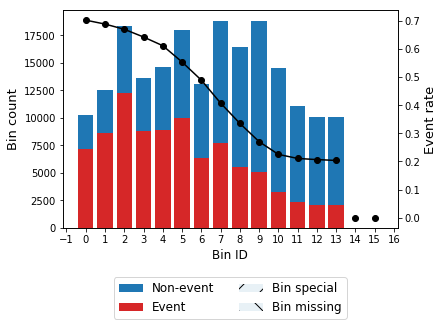

In [29]:
evs_optb0.binning_table.plot(metric="event_rate")

The expected value solution applied to scenarion 0 does not satisfy the ``min_bin_size`` constraint, hence the solution is not feasible.

In [30]:
EVS_0 = 0.594974

**Scenario 1: Good (Optimistic)**

In [31]:
bt1 = sboptb.binning_table_scenario(scenario_id=1)
bt1.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.29)",9840,0.09840,1126,8714,0.885569,-2.146624,0.347828,0.036679
1,"[0.29, 0.34)",19693,0.19693,3242,16451,0.835373,-1.724560,0.490885,0.054734
2,"[0.34, 0.43)",34376,0.34376,15318,19058,0.554398,-0.318823,0.034926,0.004347
3,"[0.43, inf)",36091,0.36091,32821,3270,0.090604,2.205914,1.226988,0.128301
4,Special,0,0.00000,0,0,0.000000,0.000000,0.000000,0.000000
5,Missing,0,0.00000,0,0,0.000000,0.000000,0.000000,0.000000
Totals,,100000,1.00000,52507,47493,0.474930,,2.100627,0.224061


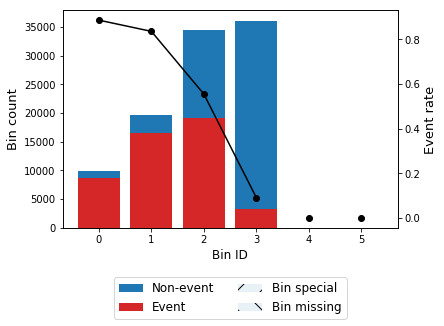

In [32]:
bt1.plot(metric="event_rate")

In [33]:
optb1 = OptimalBinning(monotonic_trend="descending", min_bin_size=0.05)
optb1.fit(x1, y1)

OptimalBinning(min_bin_size=0.05, monotonic_trend='descending')

In [34]:
optb1.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.28)",8209,0.08209,908,7301,0.889390,-2.184886,0.298095,0.031264
1,"[0.28, 0.30)",5545,0.05545,738,4807,0.866907,-1.974249,0.172075,0.018581
2,"[0.30, 0.31)",5186,0.05186,777,4409,0.850174,-1.836327,0.143301,0.015756
3,"[0.31, 0.33)",5837,0.05837,956,4881,0.836217,-1.730712,0.146359,0.016307
4,"[0.33, 0.34)",5176,0.05176,1077,4099,0.791924,-1.436928,0.094544,0.010896
5,"[0.34, 0.36)",7055,0.07055,1760,5295,0.750532,-1.201813,0.093706,0.011056
6,"[0.36, 0.38)",8537,0.08537,2882,5655,0.662411,-0.774420,0.049704,0.006062
7,"[0.38, 0.40)",6189,0.06189,2802,3387,0.547261,-0.289975,0.005205,0.000648
8,"[0.40, 0.41)",5058,0.05058,2862,2196,0.434164,0.164519,0.001360,0.000170
9,"[0.41, 0.44)",8246,0.08246,5781,2465,0.298933,0.752021,0.043766,0.005345


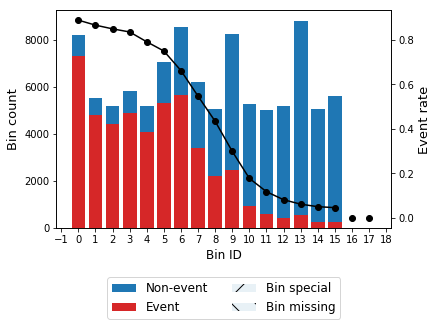

In [35]:
optb1.binning_table.plot(metric="event_rate")

Apply expected value solution to scenario 1.

In [36]:
evs_optb1 = OptimalBinning(user_splits=optb.splits)
evs_optb1.fit(x1, y1)

OptimalBinning(user_splits=array([0.1008646 , 0.13640077, 0.17635711, 0.20390539, 0.23334569,
       0.27135116, 0.30051835, 0.34623086, 0.38964605, 0.44464479,
       0.49356021, 0.53990114, 0.59801421]))

In [37]:
evs_optb1.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.20)",247,0.00247,26,221,0.894737,-2.240430,0.009316,0.000969
1,"[0.20, 0.23)",1092,0.01092,118,974,0.891941,-2.211091,0.040377,0.004219
2,"[0.23, 0.27)",5037,0.05037,566,4471,0.887632,-2.167137,0.180654,0.018995
3,"[0.27, 0.30)",7918,0.07918,1019,6899,0.871306,-2.012919,0.253339,0.027214
4,"[0.30, 0.35)",18126,0.18126,3313,14813,0.817224,-1.598015,0.397590,0.045005
5,"[0.35, 0.39)",17091,0.17091,5742,11349,0.664034,-0.781686,0.101310,0.012351
6,"[0.39, 0.44)",18095,0.18095,11857,6238,0.344736,0.541895,0.051194,0.006322
7,"[0.44, 0.49)",14295,0.14295,12739,1556,0.108849,2.002186,0.420164,0.045199
8,"[0.49, 0.54)",10111,0.10111,9523,588,0.058154,2.684374,0.453620,0.044133
9,"[0.54, 0.60)",6215,0.06215,5918,297,0.047788,2.891658,0.307832,0.028976


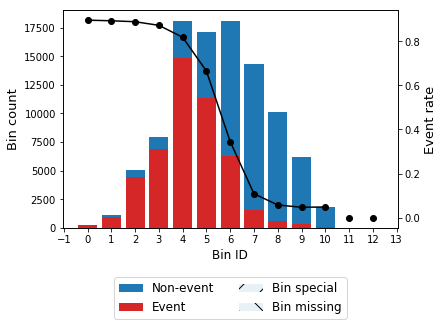

In [38]:
evs_optb1.binning_table.plot(metric="event_rate")

In [39]:
evs_optb1.binning_table.analysis()

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.72566718
    IV (Jeffrey)             2.30210757
    JS (Jensen-Shannon)      0.24158211
    Hellinger                0.26182242
    Triangular               0.84830395
    KS                       0.61004329
    HHI                      0.13857518
    HHI (normalized)         0.06678978
    Cramer's V               0.64902999
    Quality score            0.00000000

  Monotonic trend                valley

  Significance tests

    Bin A  Bin B  t-statistic       p-value  P[A > B]     P[B > A]
        0      1     0.016401  8.980961e-01  0.566231 4.337689e-01
        1      2     0.168135  6.817748e-01  0.666387 3.336129e-01
        2      3     7.641448  5.704212e-03  0.997457 2.543322e-03
        3      4   116.236493  4.218674e-27  1.000000 1.110223e-16
        4      5  1080.747496 5.050568e-237

The expected value solution applied to scenario 1 satisfies neither the ``min_bin_size`` constraint nor the monotonicity constraint, hence the solution is not feasible.

In [40]:
EVS_1 = -np.inf

**Scenario 2: Bad (Pessimistic)**

In [41]:
bt2 = sboptb.binning_table_scenario(scenario_id=2)
bt2.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.29)",15987,0.15987,5976,10011,0.626196,-0.310979,0.015099,0.001880
1,"[0.29, 0.34)",11554,0.11554,5090,6464,0.559460,-0.034016,0.000133,0.000017
2,"[0.34, 0.43)",25855,0.25855,11998,13857,0.535950,0.060904,0.000962,0.000120
3,"[0.43, inf)",46604,0.46604,21830,24774,0.531585,0.078445,0.002878,0.000360
4,Special,0,0.00000,0,0,0.000000,0.000000,0.000000,0.000000
5,Missing,0,0.00000,0,0,0.000000,0.000000,0.000000,0.000000
Totals,,100000,1.00000,44894,55106,0.551060,,0.019072,0.002376


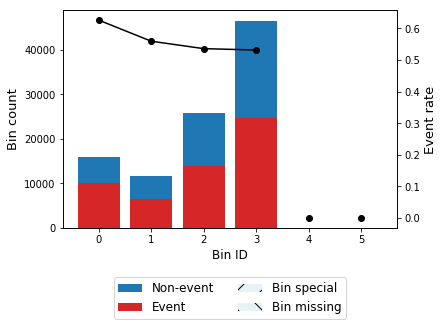

In [42]:
bt2.plot(metric="event_rate")

In [43]:
optb2 = OptimalBinning(monotonic_trend="descending", min_bin_size=0.05)
optb2.fit(x2, y2)

OptimalBinning(min_bin_size=0.05, monotonic_trend='descending')

In [44]:
optb2.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.23)",7556,0.07556,2543,5013,0.663446,-0.473736,0.016261,0.002014
1,"[0.23, 0.29)",9657,0.09657,3918,5739,0.594284,-0.176749,0.002982,0.000372
2,"[0.29, 0.33)",8559,0.08559,3801,4758,0.555906,-0.019609,0.000033,0.000004
3,"[0.33, 0.39)",15848,0.15848,7234,8614,0.543539,0.030358,0.000146,0.000018
4,"[0.39, inf)",58380,0.58380,27398,30982,0.530695,0.082018,0.003941,0.000493
5,Special,0,0.00000,0,0,0.000000,0.000000,0.000000,0.000000
6,Missing,0,0.00000,0,0,0.000000,0.000000,0.000000,0.000000
Totals,,100000,1.00000,44894,55106,0.551060,,0.023364,0.002901


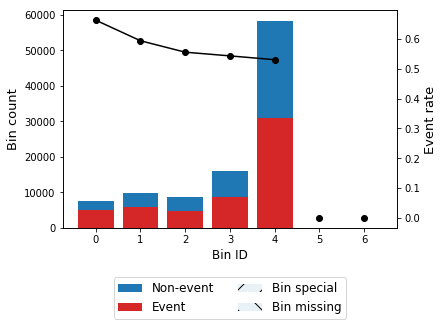

In [45]:
optb2.binning_table.plot(metric="event_rate")

Apply expected value solution to scenario 2.

In [46]:
evs_optb2 = OptimalBinning(user_splits=optb.splits)
evs_optb2.fit(x2, y2)

OptimalBinning(user_splits=array([0.1008646 , 0.13640077, 0.17635711, 0.20390539, 0.23334569,
       0.27135116, 0.30051835, 0.34623086, 0.38964605, 0.44464479,
       0.49356021, 0.53990114, 0.59801421]))

In [47]:
evs_optb2.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.14)",1292,0.01292,405,887,0.686533,-0.579003,0.004096,5.050214e-04
1,"[0.14, 0.18)",1850,0.01850,598,1252,0.676757,-0.533952,0.005019,6.200181e-04
2,"[0.18, 0.20)",2002,0.02002,709,1293,0.645854,-0.395910,0.003037,3.771741e-04
3,"[0.20, 0.23)",2944,0.02944,1049,1895,0.643682,-0.386427,0.004259,5.291176e-04
4,"[0.23, 0.27)",5326,0.05326,2134,3192,0.599324,-0.197695,0.002054,2.563524e-04
5,"[0.27, 0.30)",5390,0.05390,2291,3099,0.574954,-0.097137,0.000506,6.318381e-05
6,"[0.30, 0.35)",10414,0.10414,4667,5747,0.551853,-0.003207,0.000001,1.338664e-07
7,"[0.35, 0.39)",11782,0.11782,5375,6407,0.543796,0.029322,0.000101,1.267992e-05
8,"[0.39, 0.44)",15901,0.15901,7509,8392,0.527766,0.093778,0.001404,1.754450e-04
9,"[0.44, 0.54)",23757,0.23757,11416,12341,0.519468,0.127043,0.003854,4.814509e-04


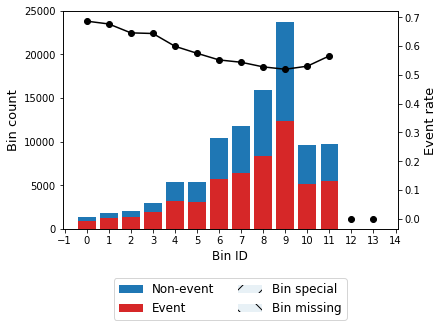

In [48]:
evs_optb2.binning_table.plot(metric="event_rate")

In [49]:
evs_optb2.binning_table.analysis()

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.07657686
    IV (Jeffrey)             0.02536981
    JS (Jensen-Shannon)      0.00315023
    Hellinger                0.00316066
    Triangular               0.01251904
    KS                       0.05109803
    HHI                      0.13267476
    HHI (normalized)         0.06595743
    Cramer's V               0.07812501
    Quality score            0.00318975

  Monotonic trend                valley

  Significance tests

    Bin A  Bin B  t-statistic      p-value     P[A > B]  P[B > A]
        0      1     0.334525 5.630065e-01 7.193040e-01  0.280696
        1      2     4.095897 4.298741e-02 9.789856e-01  0.021014
        2      3     0.024540 8.755193e-01 5.627139e-01  0.437286
        3      4    15.757594 7.199834e-05 9.999743e-01  0.000026
        4      5     6.563219 1.041079e-02 9.951

The expected value solution applied to scenario 2 satisfies neither the ``min_bin_size`` constraint nor the monotonicity constraint, hence the solution is not feasible.

In [50]:
EVS_2 = -np.inf

### Expected value of perfect information (EVPI)

If we have prior information about the incoming economic scenarios, we could take optimal solutions for each scenario, with total IV:

In [51]:
DIV0 = optb0.binning_table.iv
DIV1 = optb1.binning_table.iv
DIV2 = optb2.binning_table.iv
DIV = (DIV0 + DIV1 + DIV2) / 3

In [52]:
DIV

0.9990011753826167

However, this information is unlikely to be available in advance, so the best we can do in the long run is to use the stochastic programming, with expected total IV:

In [53]:
SIV = sboptb.binning_table.iv

In [54]:
SIV

0.37573524671618974

The difference, in the case of perfect information, is the expected value of perfect information (EVPI) given by:

In [55]:
EVPI = DIV - SIV
EVPI

0.6232659286664269

### Value of stochastic solution (VSS)

The loss in IV by not considering stochasticity is the difference between the application of the expected value solution for each scenario and the stochastic model IV. The application of the EVS to each scenario results in infeasible solutions, thus

In [56]:
VSS = SIV - (EVS_0 + EVS_1 + EVS_2)
VSS

inf